In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from scipy.stats import pmean
import sys
import plot_settings
import matplotlib.ticker as tk
import matplotlib as mpl
from tqdm import tqdm
import torch
device = 'cuda:0'
def to_numeric(val: str):
    try:
        return int(val)
    except ValueError:
        return float(val)
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']= 'STIXGeneral'
mpl.rcParams['mathtext.fontset']= 'stix'
mpl.rcParams['font.size']= 24
def read_ising(path: str, scale: float):
    with open(path) as infile:
        if '.ising' in path:
            nodes, nlin, edges = map(int, infile.readline().strip().split())
            # const = float(infile.readline())
            const=0
            offset = 0
        else:
            offset = 0 if '.gset' in path else 1
            nodes, edges = map(int, infile.readline().strip().split())
            const = 0
            nlin = 0
        h = torch.zeros(nodes, device=device)
        J = torch.zeros((nodes, nodes), device=device)
        for i in range(nlin):
            args = infile.readline().strip().split()
            u, val = map(to_numeric, args)
            h[u-offset] = val
        for i in range(edges):
            args = infile.readline().strip().split()
            u, v, val = map(to_numeric, args)
            J[u-offset][v-offset] = -val
            J[v-offset][u-offset] = -val
        h /= scale
        J /= scale
        h /= J.abs().max()
        J /= J.abs().max()
        return h, J, const

(tensor([-46.7002, -26.2701, -26.2700, -25.0258, -25.0257, -23.0936, -23.0924,
         -20.6685, -20.6684, -18.0031, -18.0030, -17.9730, -17.9684, -17.9609,
         -17.9518, -17.9474, -17.9291, -17.9164, -17.9106, -17.8914, -17.8756,
         -17.8292, -17.8100, -17.7676, -17.7443, -17.6490, -17.4578, -17.0315,
         -16.4970, -15.3714, -15.3713, -14.2532, -13.0470, -13.0470, -11.2589,
         -11.2589, -10.1533, -10.1532,  -9.7833,  -1.5859,  -1.4230,  -1.4230,
          -0.9370,  -0.9370,  -0.1538,  -0.1538,   0.5099,   0.5821,   0.5821,
           0.7923,   0.7923,   0.8591,   0.8591,   1.1211,   1.1211,   1.2400,
           1.2667,   1.2667,   1.3522,   1.3522,   1.5053,   1.5064,   1.5065,
           1.5249,   1.5249,   1.5373,   1.5373,   1.5870,   1.5870,   1.6610,
           1.6762,   1.6762,   1.6935,   1.6935,   1.7219,   1.7220,   1.7288,
           1.7289,   1.7492,   1.7608,   1.7608,   1.7657,   1.7770,   1.7771,
           1.7953,   1.7953,   1.7962,   1.7962,   1

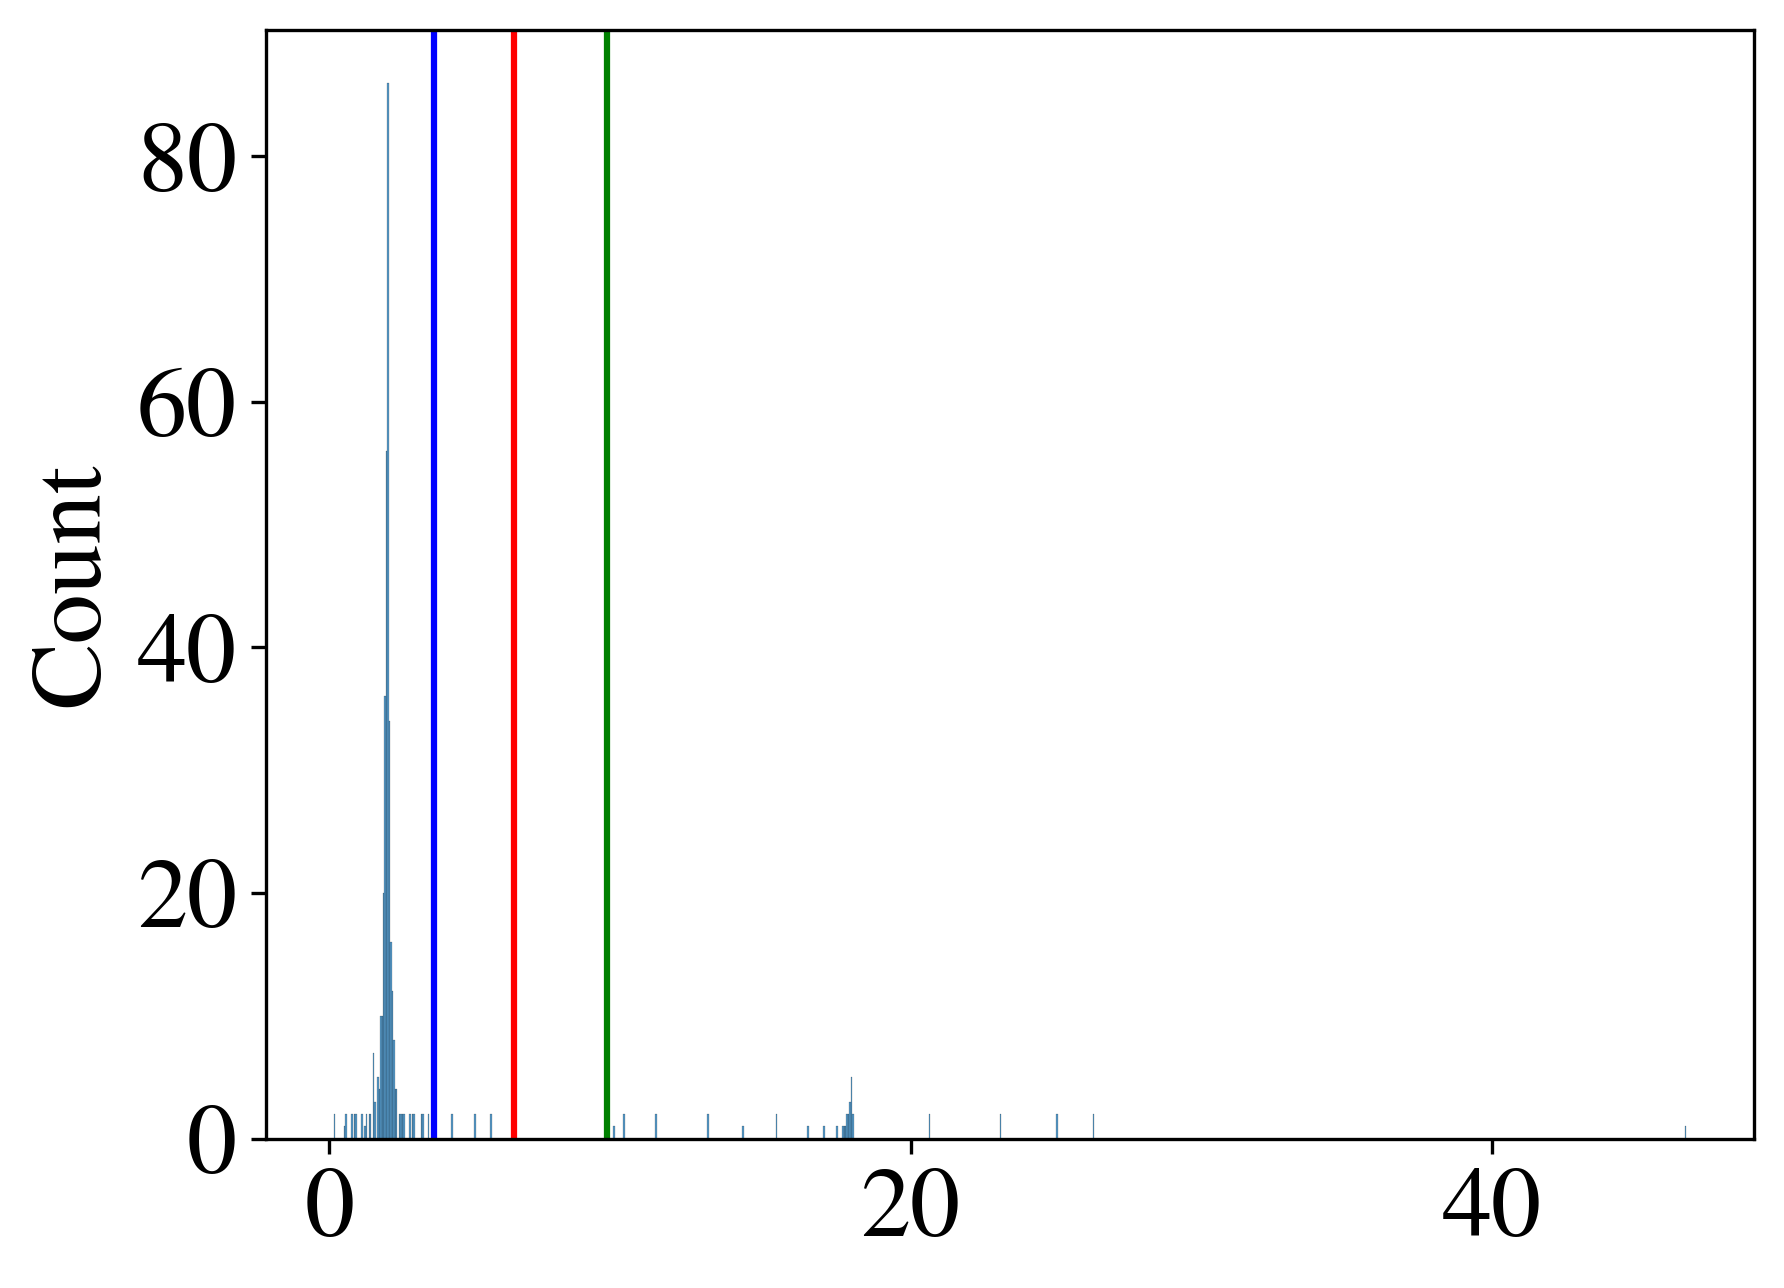

In [63]:
h, J, const = read_ising('../tsp_problems/tsp_ising/RNG_TSP_20_0.ising', 1.0)

eig = torch.linalg.eigvalsh(J).abs()
eig_other, eigvecs = torch.linalg.eigh(J)
rad = eig.max().item()
meanval = pmean(eig.cpu().numpy(),2)
stdval = eig.std().item()
ax=sns.histplot(eig.cpu().numpy())
ax.axvline(pmean(eig.cpu().numpy(),1), color='blue')
ax.axvline(pmean(eig.cpu().numpy(),2), color='red')
ax.axvline(pmean(eig.cpu().numpy(),3), color='green')
eig_other, eig, eigvecs[:,0]

In [57]:
import re
tspdir = '../tsp_problems/tsp_ising'
paths = list(filter(lambda x: int(re.findall(r'(\d+)\.ising', x)[0])  < 5, os.listdir(tspdir)))
eigdata = []
for p in tqdm(paths):
    h, J, const = read_ising(f'{tspdir}/{p}', 1.0)

    eig = torch.linalg.eigvalsh(J).abs()
    rad = eig.max().item()
    meanval = pmean(eig.cpu().numpy(), 3)
    stdval = eig.std().item()
    # sns.histplot
    eigdata.append((p, rad, meanval))

100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


In [58]:
eig_df = pd.DataFrame(eigdata, columns=['graph', 'eigmax', 'eigmean'])
eig_df['cities'] = eig_df['graph'].str.extract(r'TSP_(\d+)').astype(int)
eig_df = eig_df.groupby('cities').mean(numeric_only=True).reset_index()
# eig_df.groupby('cities').std(numeric_only=True).reset_index()

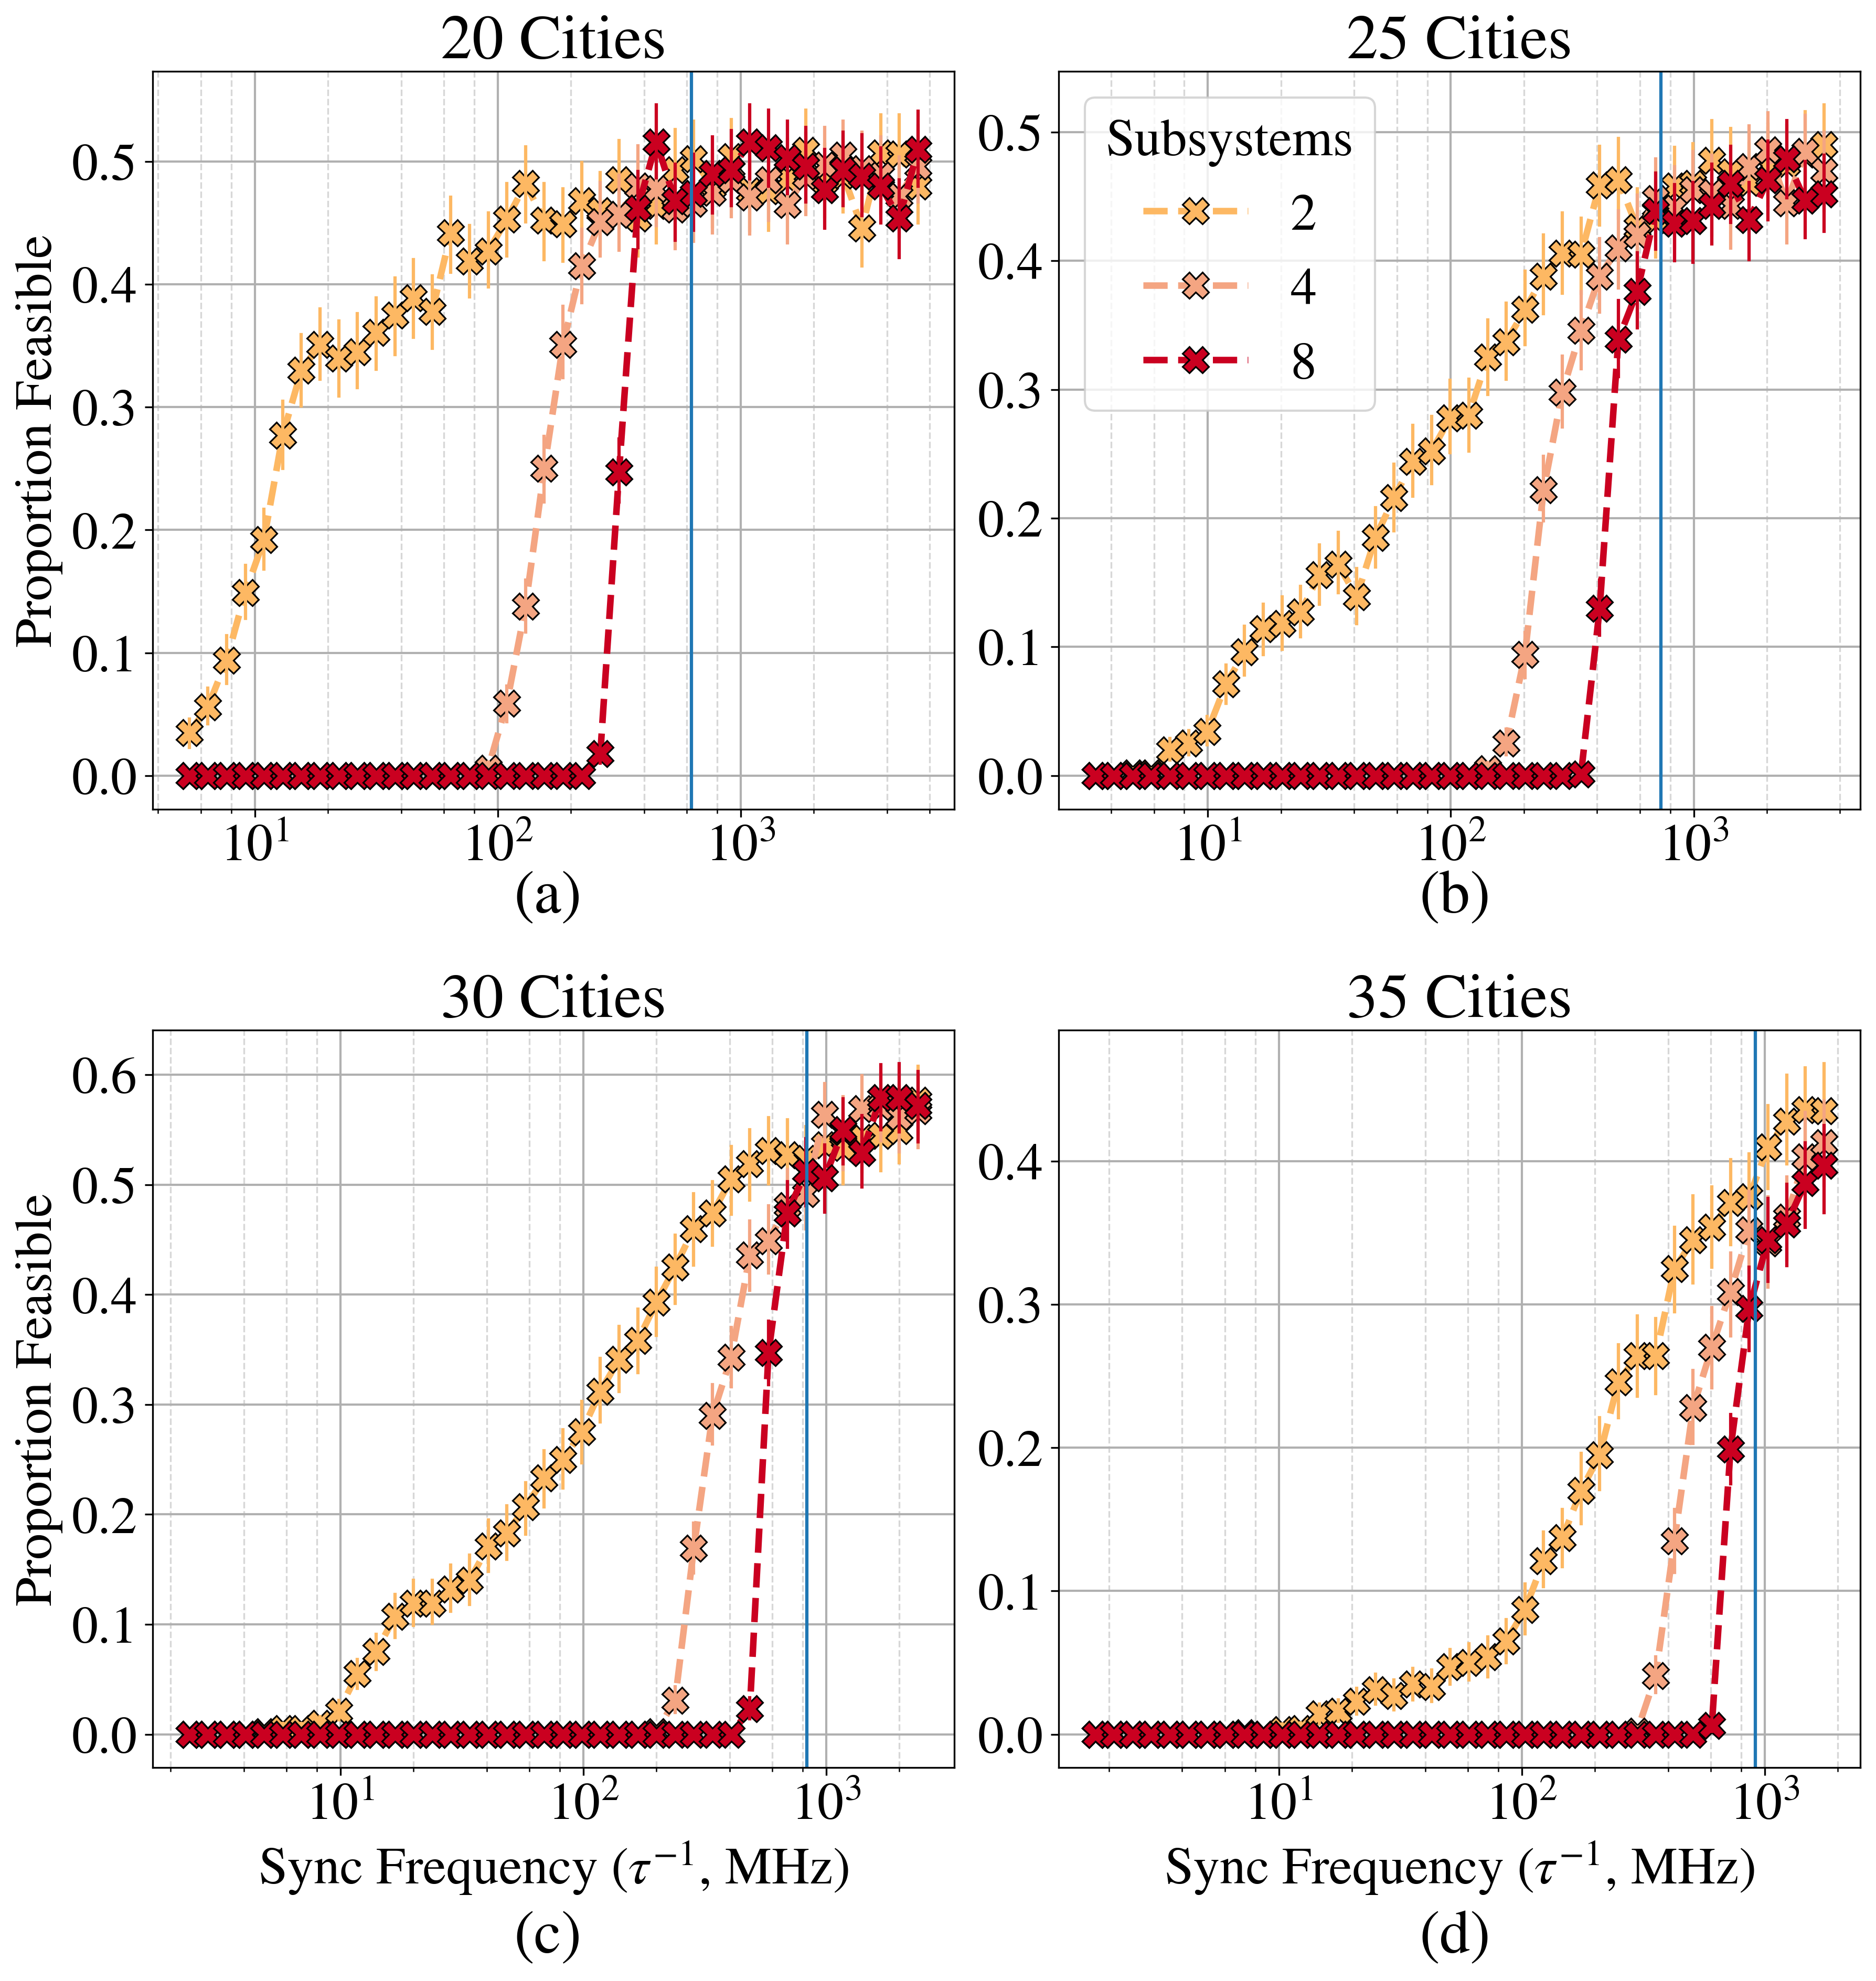

In [59]:
df = pd.read_csv('../rng_euc2d_feasibility.csv')
df['Subsystems'] = df['blocks']
# df = df.merge(eig_df, on='cities')
df['Sync Frequency ($\\tau^{-1}$, MHz)'] = 1 / df['epoch'] / (31e4*50e-15) / 1e6
# mpl.rcParams['font.size'] = 20
palette = [ 
#     "#404040",
            "#fdb863",
            "#f4a582",
            "#ca0020",]
kwargs = dict(
    hue='Subsystems', x='Sync Frequency ($\\tau^{-1}$, MHz)', y='feasible', palette=palette,
    linestyle='--',
    marker='X',
    markersize=12,
    linewidth=3,
    err_style='bars',
    markeredgecolor='black',
    # palette=palette

)
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(14, 14), dpi=300, gridspec_kw={'hspace': 0.3, 'wspace': 0.13})
ax=axs[0][0]
sns.lineplot(ax=ax, data=df.query('cities==20'), **kwargs)

eig1 = (49e-15 * 31e4) / eig_df.query('cities == 20')['eigmean'].mean()
ax.axvline(1/eig1 / 1e6)
ax.set_xscale('log')
ax.set_title(f'20 Cities')

ax=axs[0][1]
sns.lineplot(ax=ax, data=df.query('cities==25'), **kwargs)
eig1 = (49e-15 * 31e4) / eig_df.query('cities == 25')['eigmean'].mean()
ax.axvline(1/eig1 / 1e6)
ax.set_xscale('log')
ax.set_title(f'25 Cities')

ax=axs[1][0]
sns.lineplot(ax=ax, data=df.query('cities==30'), **kwargs)
eig1 = (49e-15 * 31e4) / eig_df.query('cities == 30')['eigmean'].mean()
ax.axvline(1/eig1 / 1e6)
ax.set_xscale('log')
ax.set_title(f'30 Cities')

ax=axs[1][1]
sns.lineplot(ax=ax, data=df.query('cities==35'), **kwargs)
eig1 = (49e-15 * 31e4) / eig_df.query('cities == 35')['eigmean'].mean()
ax.axvline(1/eig1 / 1e6)
ax.set_xscale('log')
ax.set_title(f'35 Cities')
for ax in axs.flatten():
    ax.set_ylabel('Proportion Feasible')
    ax.grid()
for ax, label in zip(axs[0], ['a', 'b']):
    ax.set_xlabel('')
    ax.annotate(text=f"({label})", xy=(0.45, -0.14), xycoords='axes fraction', fontsize=28)
for ax, label in zip(axs[1], ['c', 'd']):
    ax.annotate(text=f"({label})", xy=(0.45, -0.25), xycoords='axes fraction', fontsize=28)
axs[0][1].set_ylabel('')
axs[1][1].set_ylabel('')
axs[0][0].legend_ = None
axs[1][1].legend_ = None
axs[1][0].legend_ = None
for ax in axs.flatten():
    ax.grid(which='minor', linestyle='--', alpha=0.5)
    ax.grid(which='major', linewidth=1)
    # ax.yaxis.set_major_locator(tk.LogLocator(base=10, subs=[1]))
    # ax.yaxis.set_minor_locator(tk.LogLocator(base=10, subs=[2, 4, 6, 8]))
    ax.xaxis.set_major_locator(tk.LogLocator(base=10, subs=[1]))
    ax.xaxis.set_minor_locator(tk.LogLocator(base=10, subs=[2, 4, 6, 8]))
fig.savefig('../figures/feasibility_concurrent.pdf', bbox_inches='tight', dpi=300)